In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

import matplotlib as mpt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as patches

import numpy as np
from scipy import optimize
import os

from JJ_data_processing import *
from JJformulas import *

#from tqdm import tqdm, tqdm_notebook
from tqdm.autonotebook import tqdm

from scipy.optimize import curve_fit


D:\anaconda\lib\site-packages\qcodes\dataset\database.py:13: UserWarning: The module `qcodes.dataset.database` is deprecated.
Public features are available at the import of `qcodes`.
Private features are available in `qcodes.dataset.sqlite.*` modules.
  warnings.warn('The module `qcodes.dataset.database` is deprecated.\n'
D:\anaconda\lib\site-packages\tqdm\autonotebook\__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [2]:
import qcodes as qc
from qcodes.dataset.database import initialise_database
from qcodes.dataset.plotting import plot_by_id, get_data_by_id

## Populate exps

In [139]:

def populate_exps (exps, ZF_ = .000e-3, FF_ = .21e-3, VERBOSE = False,
                   N = 0, Gap = 437e-6, dy = 30e-6):

    texps = tqdm_notebook(exps)
    for exp in texps:

        Isws_n = [ [ ] for i in range (N+1)]
        R0s_n =  [ [ ] for i in range (N+1)]

        if VERBOSE:
            fig, ax = plt.subplots()

        Is_B = [ [ ] for i in range (len(exp['ids']))]
        Vs_B = [ [ ] for i in range (len(exp['ids']))]


        for j,i in enumerate(exp['ids']):
            
            Is_n = [ [ ] for i in range (N+1)]
            Vs_n = [ [ ] for i in range (N+1)]
            
            I, V = xy_by_id(i)

            I = np.array_split(I,4)[0]
            V = np.array_split(V,4)[0]
            
            V = V - V[-1] + Gap*N
            
            Tb = exp['T']
            
            if VERBOSE:
                ax.plot(I, V, '.-', alpha = 0.2)
                

            for n in range(N+1):
                
                I_cut, V_cut = cut_dxdy(I, V - n*Gap, 
                                        dx = 250e-9 ,dy = dy)


                if VERBOSE:
                    ax.plot(I_cut, V_cut + n*Gap, 'o')
                    ax.hlines(n*Gap, 0,0.1e-9, alpha = 0.2)

                Isw, R0 = extract_Isw_R0 (I_cut, V_cut)
            
                Isws_n[n].append(Isw)
                R0s_n[n].append(R0)
                
                Is_n[n] = np.array(I)
                Vs_n[n] = np.array(V)
                
            Is_B[j] = np.array(Is_n)
            Vs_B[j] = np.array(Vs_n)

            


            exp ['Is_Bn' ] =  Is_B
            exp ['Vs_Bn' ] =  Vs_B

            exp ['Is' ] =  Is_B[:][0]
            exp ['Vs' ] =  Vs_B[:][0]

            exp ['Isws' ] =  Isws_n[0]
            

            exp ['Isws_n'] =  np.array(Isws_n) 
            exp ['R0s_n' ] =  np.array(R0s_n )


        exp ['cos' ] =  np.array( abs(np.cos(np.pi*(exp['B'] - ZF_ )/(2* (FF_ - ZF_)  )) ) )


In [171]:

def populate_exps_stat (exps, ZF_ = .000e-3, FF_ = .21e-3, VERBOSE = False,
                   N = 0, Gap = 437e-6, dy = 30e-6):

    texps = tqdm_notebook(exps)
    for exp in texps:

        Isws_n = [ [ ] for i in range (N+1)]
        R0s_n =  [ [ ] for i in range (N+1)]

        if VERBOSE:
            fig, ax = plt.subplots()

        Is_B = [ [ ] for i in range (len(exp['ids']))]
        Vs_B = [ [ ] for i in range (len(exp['ids']))]


        
        for j,i in enumerate(exp['ids']):
            
            Is_n = [ [ ] for i in range (N+1)]
            Vs_n = [ [ ] for i in range (N+1)]
            
            I, V = xy_by_id(i)

#             I = np.array_split(I,4)[0]
#             V = np.array_split(V,4)[0]
            
            V = V - V[-1] + Gap*N
            
            Tb = exp['T']
            
            if VERBOSE:
                ax.plot(I, V, '.-', alpha = 0.2)
                

            for n in range(N+1):
                
                I_cut, V_cut = cut_dxdy(I, V - n*Gap, 
                                        dx = 250e-9 ,dy = dy)


                if VERBOSE:
                    ax.plot(I_cut, V_cut + n*Gap, 'o')
                    ax.hlines(n*Gap, 0,2e-9, alpha = 0.2)

                Isw, R0 = extract_Isw_R0 (I_cut, V_cut)
            
                Isws_n[n].append(Isw)
                R0s_n[n].append(R0)
                
                Is_n[n] = np.array(I)
                Vs_n[n] = np.array(V)
                
            Is_B[j] = np.array(Is_n)
            Vs_B[j] = np.array(Vs_n)

            


            exp ['Is_Bn' ] =  Is_B
            exp ['Vs_Bn' ] =  Vs_B

            exp ['Is' ] =  Is_B[:][0]
            exp ['Vs' ] =  Vs_B[:][0]

            exp ['Isws' ] =  Isws_n[0]
            

            exp ['Isws_n'] =  np.array(Isws_n) 
            exp ['R0s_n' ] =  np.array(R0s_n )


        exp ['cos' ] =  np.array( abs(np.cos(np.pi*(exp['B'] - ZF_ )/(2* (FF_ - ZF_)  )) ) )


In [24]:
def fit_hist_by_id(idx, EJ = 4, Ec = 0.05, dIdt = 30e-9, bins = 21):

    def wpK(EjK, EcK):
        return np.sqrt(8*EjK*EcK)
    
    eps = .001
    
    Isw = abs(load_hist_by_id(idx ))

    counts, Ibins = np.histogram(Isw, bins = bins)
    dI = np.mean( np.diff(Ibins) )

    SP = np.cumsum(counts)/len(Isw)
    Gamma = np.array([ np.log( (1 - SP[i])/(1 - SP[i+1]) ) for i in range(len(SP)-1)  ])*dIdt/dI


    Ic = 2*pi*EJ/Φ0*kB
    Ic0 = 1.5 * np.max(Isw)
    Ib = Ibins[:-2]
    
    while abs((Ic - Ic0)/Ic) > eps:
        Ic = Ic0
        wa = wpK(EJ, Ec)*kB/hbar/2/pi * (1 - (Ib/Ic)**2)**0.25

        coeff =  (-np.log(2*pi*Gamma/wa))**(2/3)
        i = np.isfinite(coeff) 
        
        a, b = np.polyfit( Ib[i], coeff[i],1)
        Ic0 = -b/a
        Teff = -1/kB*Φ0/2/pi*4*np.sqrt(2)/3 /np.sqrt(b)/a
    

    return Ic0, Teff

In [26]:
def load_hist_by_id(idx):
    _, Isws = xy_by_id(idx)
    return Isws

# 78N5

In [3]:
SAMPLE = 'D078N5'

qc.config["core"]["db_location"] = os.getcwd() + '\..\ExdData\Experiments_{}.db'.format(SAMPLE)

# Hist

In [181]:
exp['Isws_n'][1]

array([3.2e-11, 4.4e-11,     nan, 4.4e-11,     nan,     nan, 3.6e-11,
           nan,     nan,     nan, 3.2e-11,     nan, 3.2e-11, 4.4e-11,
           nan,     nan, 4.0e-11,     nan,     nan,     nan,     nan,
       4.0e-11,     nan,     nan,     nan,     nan,     nan,     nan,
       4.0e-11, 3.6e-11,     nan,     nan, 2.8e-11, 3.6e-11, 4.0e-11,
       3.2e-11,     nan, 4.0e-11,     nan,     nan,     nan,     nan,
           nan, 4.0e-11,     nan, 2.0e-11, 4.0e-11,     nan, 4.0e-11,
           nan, 4.0e-11, 4.0e-11,     nan, 4.0e-11, 3.2e-11, 4.0e-11,
       4.4e-11, 4.0e-11,     nan,     nan,     nan,     nan,     nan,
           nan, 3.2e-11,     nan,     nan,     nan, 4.4e-11,     nan,
       3.2e-11,     nan,     nan, 4.4e-11,     nan, 4.0e-11,     nan,
       2.8e-11, 3.6e-11,     nan, 3.6e-11,     nan,     nan, 2.8e-11,
       3.6e-11,     nan, 2.4e-11, 2.8e-11, 2.8e-11, 3.2e-11, 3.6e-11,
           nan,     nan, 3.6e-11, 3.2e-11,     nan,     nan, 3.6e-11,
           nan,     

<IPython.core.display.Javascript object>


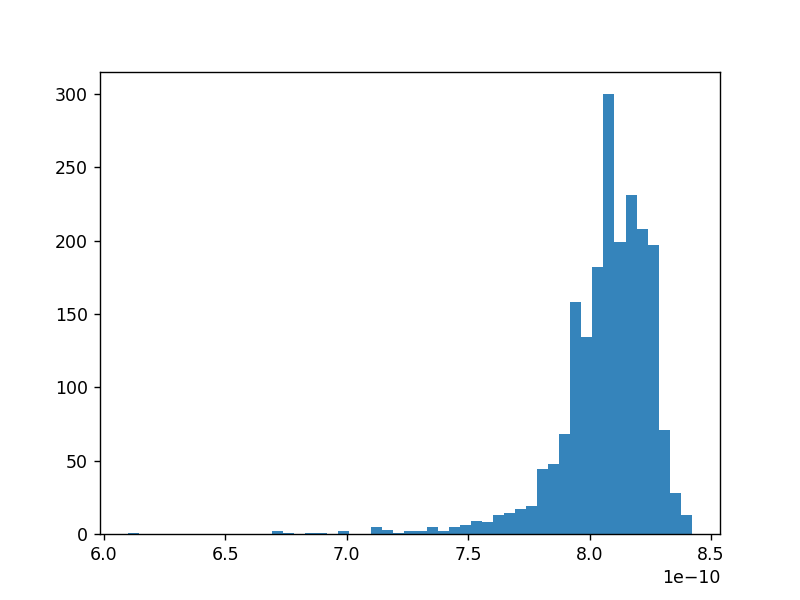

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   2.,   1.,   0.,   1.,   1.,   0.,   2.,   0.,   0.,
          5.,   3.,   1.,   2.,   2.,   5.,   2.,   5.,   6.,   9.,   8.,
         13.,  14.,  17.,  19.,  44.,  48.,  68., 158., 134., 182., 300.,
        199., 231., 208., 197.,  71.,  28.,  13.]),
 array([6.10067736e-10, 6.14616771e-10, 6.19165806e-10, 6.23714841e-10,
        6.28263876e-10, 6.32812911e-10, 6.37361946e-10, 6.41910981e-10,
        6.46460016e-10, 6.51009051e-10, 6.55558086e-10, 6.60107121e-10,
        6.64656156e-10, 6.69205191e-10, 6.73754226e-10, 6.78303261e-10,
        6.82852296e-10, 6.87401331e-10, 6.91950366e-10, 6.96499401e-10,
        7.01048436e-10, 7.05597471e-10, 7.10146506e-10, 7.14695541e-10,
        7.19244576e-10, 7.23793611e-10, 7.28342646e-10, 7.32891681e-10,
        7.37440715e-10, 7.41989750e-10, 7.46538785e-10, 7.51087820e-10,
        7.55636855e-10, 7.60185890e-10, 7.64734925e-10, 7.69283960e-10,
    

In [4]:
fig, ax = plt.subplots()

_, Isws = xy_by_id(131)


ax.hist(Isws, bins = 51, alpha = 0.9)

<IPython.core.display.Javascript object>


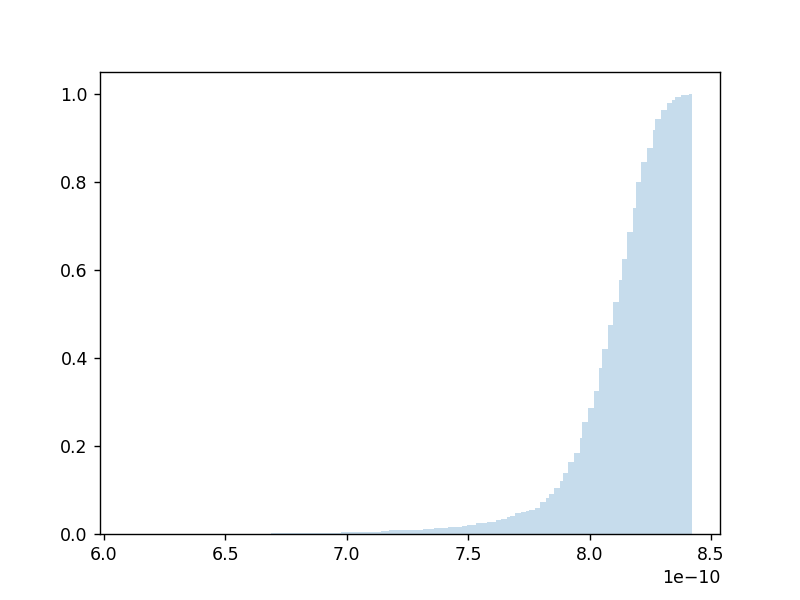

(array([5.000e-04, 5.000e-04, 5.000e-04, 5.000e-04, 5.000e-04, 5.000e-04,
        5.000e-04, 5.000e-04, 5.000e-04, 5.000e-04, 5.000e-04, 5.000e-04,
        5.000e-04, 5.000e-04, 5.000e-04, 5.000e-04, 5.000e-04, 5.000e-04,
        5.000e-04, 5.000e-04, 5.000e-04, 5.000e-04, 5.000e-04, 5.000e-04,
        5.000e-04, 5.000e-04, 5.000e-04, 5.000e-04, 5.000e-04, 5.000e-04,
        5.000e-04, 5.000e-04, 5.000e-04, 5.000e-04, 5.000e-04, 5.000e-04,
        5.000e-04, 5.000e-04, 5.000e-04, 5.000e-04, 5.000e-04, 5.000e-04,
        5.000e-04, 5.000e-04, 5.000e-04, 5.000e-04, 5.000e-04, 5.000e-04,
        5.000e-04, 5.000e-04, 5.000e-04, 1.500e-03, 1.500e-03, 1.500e-03,
        1.500e-03, 1.500e-03, 1.500e-03, 1.500e-03, 2.000e-03, 2.000e-03,
        2.000e-03, 2.000e-03, 2.000e-03, 2.000e-03, 2.500e-03, 2.500e-03,
        2.500e-03, 2.500e-03, 2.500e-03, 3.000e-03, 3.000e-03, 3.000e-03,
        3.000e-03, 3.000e-03, 3.000e-03, 3.000e-03, 4.000e-03, 4.000e-03,
        4.000e-03, 4.000e-03, 4.000e-0

In [5]:
fig, ax = plt.subplots()

_, Isws = xy_by_id(131)

ax.hist(abs(Isws), bins = 201, cumulative = True,  density = True, alpha = 0.25)


D:\anaconda\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
D:\anaconda\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in log


1.1813735523227752e-09 0.000573839848110465 0.6245270827451715
1.1813647274860152e-09 0.0005738304560830716 7.469979959013773e-06


<IPython.core.display.Javascript object>


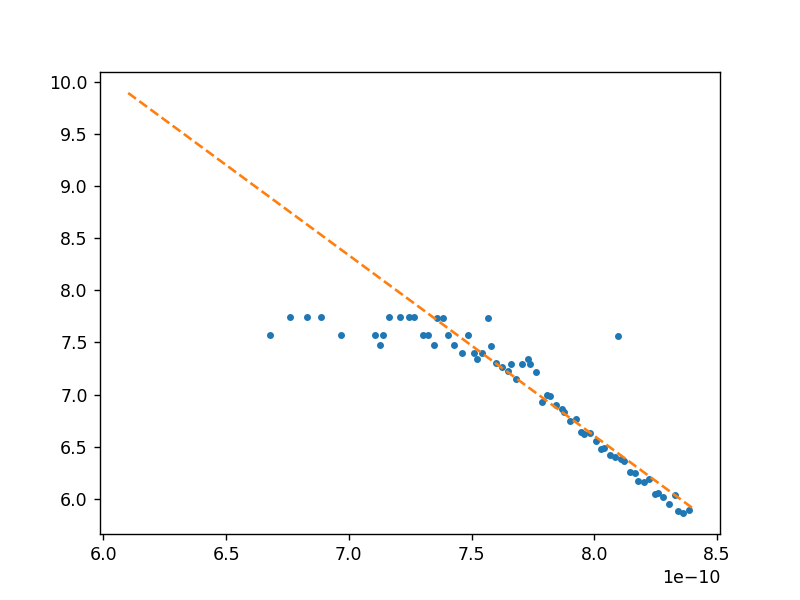

Ic0 = 1.2 nA
Teff = 0.6 mK


In [46]:
eps = .0001

_, Isw = xy_by_id(131)


counts, Ibins = np.histogram(Isw, bins = 201)
dI = np.mean( np.diff(Ibins) )

dIdt = 3e-9

SP = np.cumsum(counts)/len(Isw)
Gamma = np.array([ np.log( (1 - SP[i])/(1 - SP[i+1]) ) for i in range(len(SP)-1)  ])*dIdt/dI


EJ = .05
Ec = .05


Ic = 2*pi*EJ/Φ0*kB
Ic0 = 1.5*Ic
Ib = Ibins[:-2]

while abs((Ic - Ic0)/Ic) > eps:

    Ic = Ic0

    wa = wpK(EJ, Ec)*kB/hbar * (1 - (Ib/Ic/20)**2)**0.25

    coeff =  (-np.log(2*pi*Gamma/wa))**(2/3)

    Ib_fit     = np.array_split(Ib,2)   [-1]
    coeff_fit = np.array_split(coeff,2) [-1]
    
    idx = np.isfinite(coeff_fit) 
    
 

    a, b = np.polyfit( Ib_fit[idx], coeff_fit[idx],1)
    Ic0 = -b/a
    Teff = -1/kB*Φ0/2/pi*4*np.sqrt(2)/3 /np.sqrt(b)/a

    print(Ic0, Teff, (Ic - Ic0)/Ic)


fig, ax = plt.subplots()
ax.plot(Ib, coeff, '.')

# idx = np.isfinite(coeff) 
# a, b = np.polyfit( Ib[idx], coeff[idx],1)

ax.plot(Ib, a*Ib+b, '--') 

print('Ic0 = {:1.1f} nA'.format(Ic0*1e9))
print('Teff = {:1.1f} mK'.format(Teff*1e3))

In [28]:
fit_hist_by_id(131, EJ = .4, Ec = 0.05, dIdt = 30e-9, bins = 21)

D:\anaconda\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  
D:\anaconda\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in log


(1.2444182372722263e-09, 0.0008650937618626195)

NameError: name 'jj' is not defined